In [1]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import qr
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit, RawFeatureVector
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, SLSQP, ADAM, GradientDescent
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


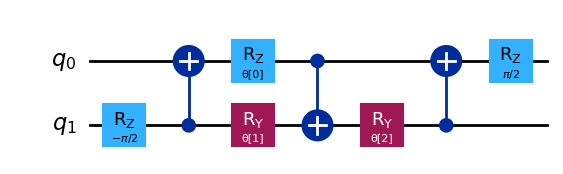

In [2]:
# We now define a two qubit unitary as defined in [3]

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

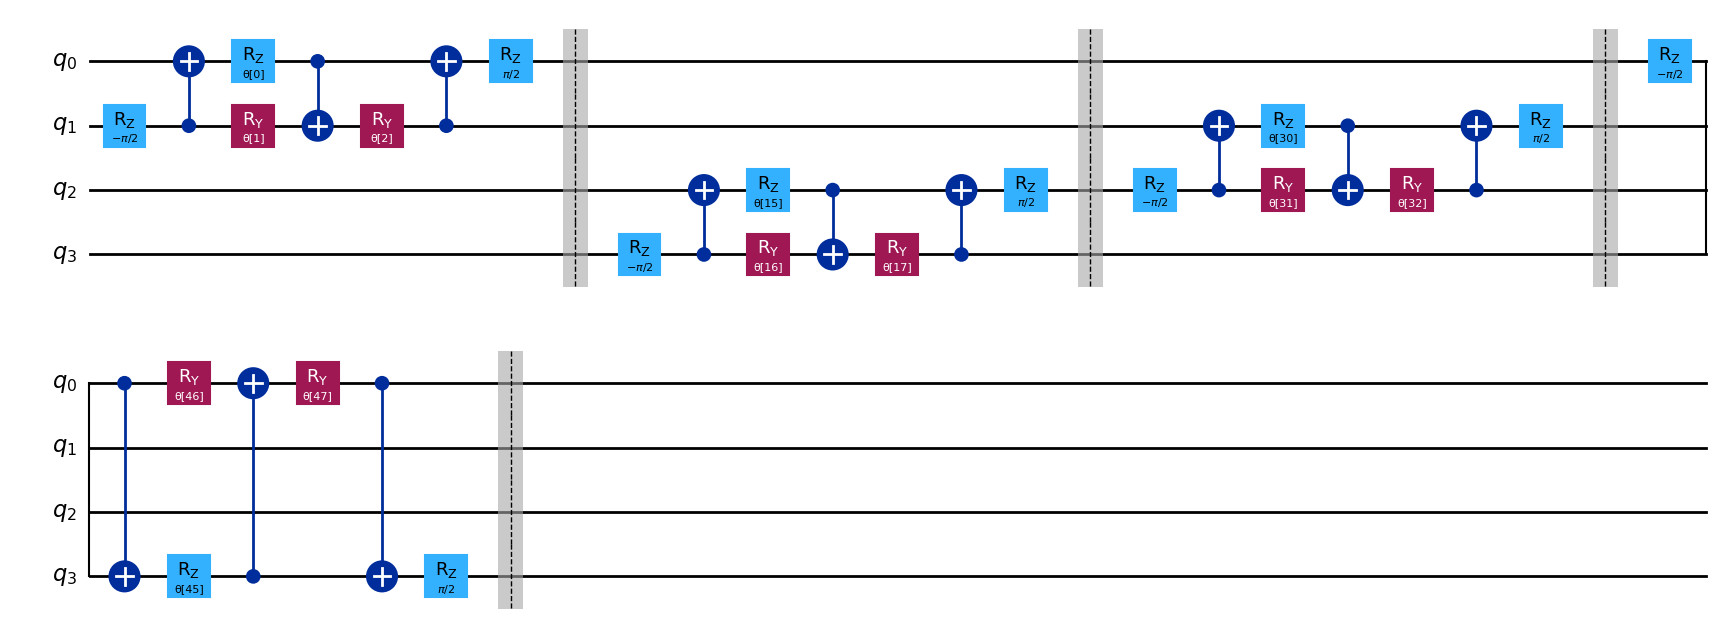

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

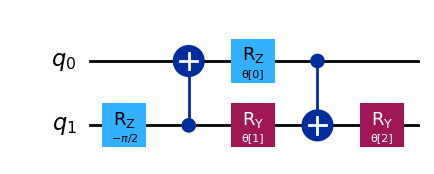

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

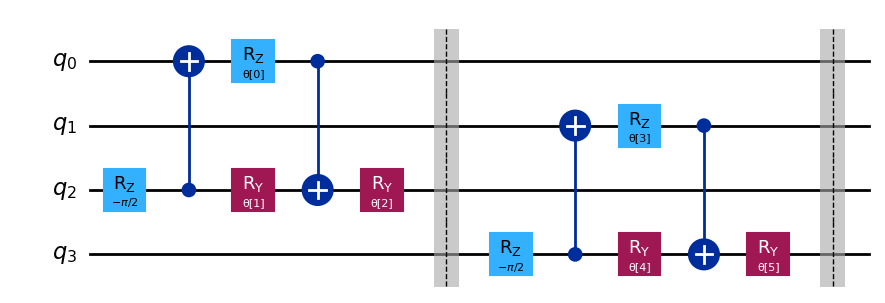

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [6]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-11-24 22:02:57.581984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732514577.595689   92369 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732514577.600002   92369 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 22:02:57.613648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [7]:
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [8]:
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


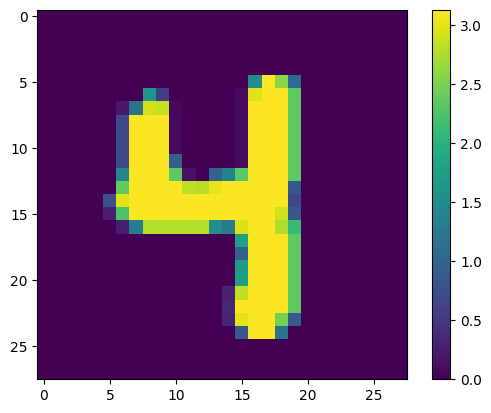

In [9]:
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [10]:
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

W0000 00:00:1732514579.391774   92369 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4


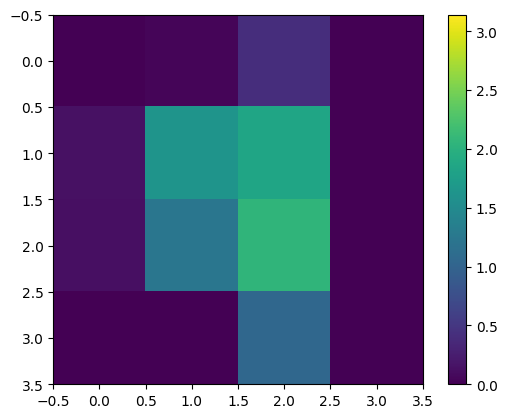

In [11]:
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [12]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
   
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass


    num_uniq_a = sum(1 for value in mapping.values() if len(value) == 1 and a in value)
    num_uniq_b = sum(1 for value in mapping.values() if len(value) == 1 and b in value)
    num_uniq_all = sum(1 for value in mapping.values() if len(value) >= 2)


    print("Number of unique images:", len(mapping.values()))
    print("Number of unique ", a, "'s: ", num_uniq_a)
    print("Number of unique ", b, "'s: ", num_uniq_b)
    print("Number of unique contradicting labels: ", num_uniq_all)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
   
    return np.asarray(new_x), np.asarray(new_y)

In [13]:
import collections
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 11973
Number of unique  3 's:  6131
Number of unique  4 's:  5842
Number of unique contradicting labels:  0

Initial number of images:  11973
Remaining non-contradicting unique images:  11973
Number of unique images: 1992
Number of unique  3 's:  1010
Number of unique  4 's:  982
Number of unique contradicting labels:  0

Initial number of images:  1992
Remaining non-contradicting unique images:  1992


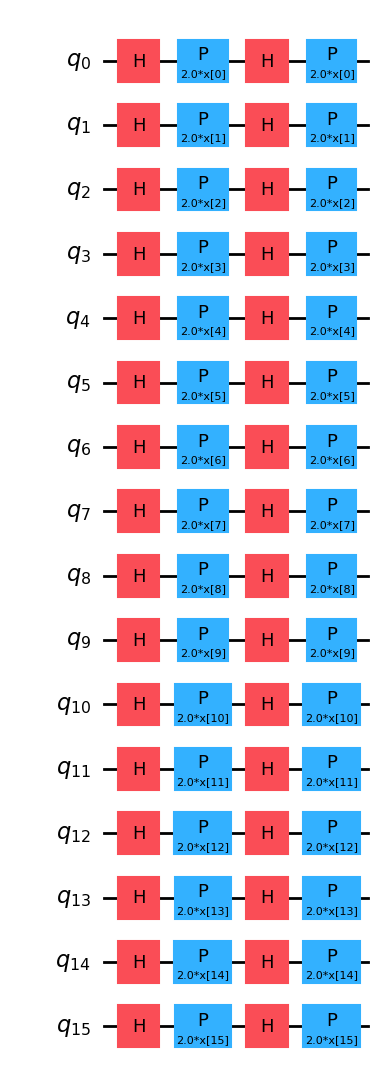

In [14]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

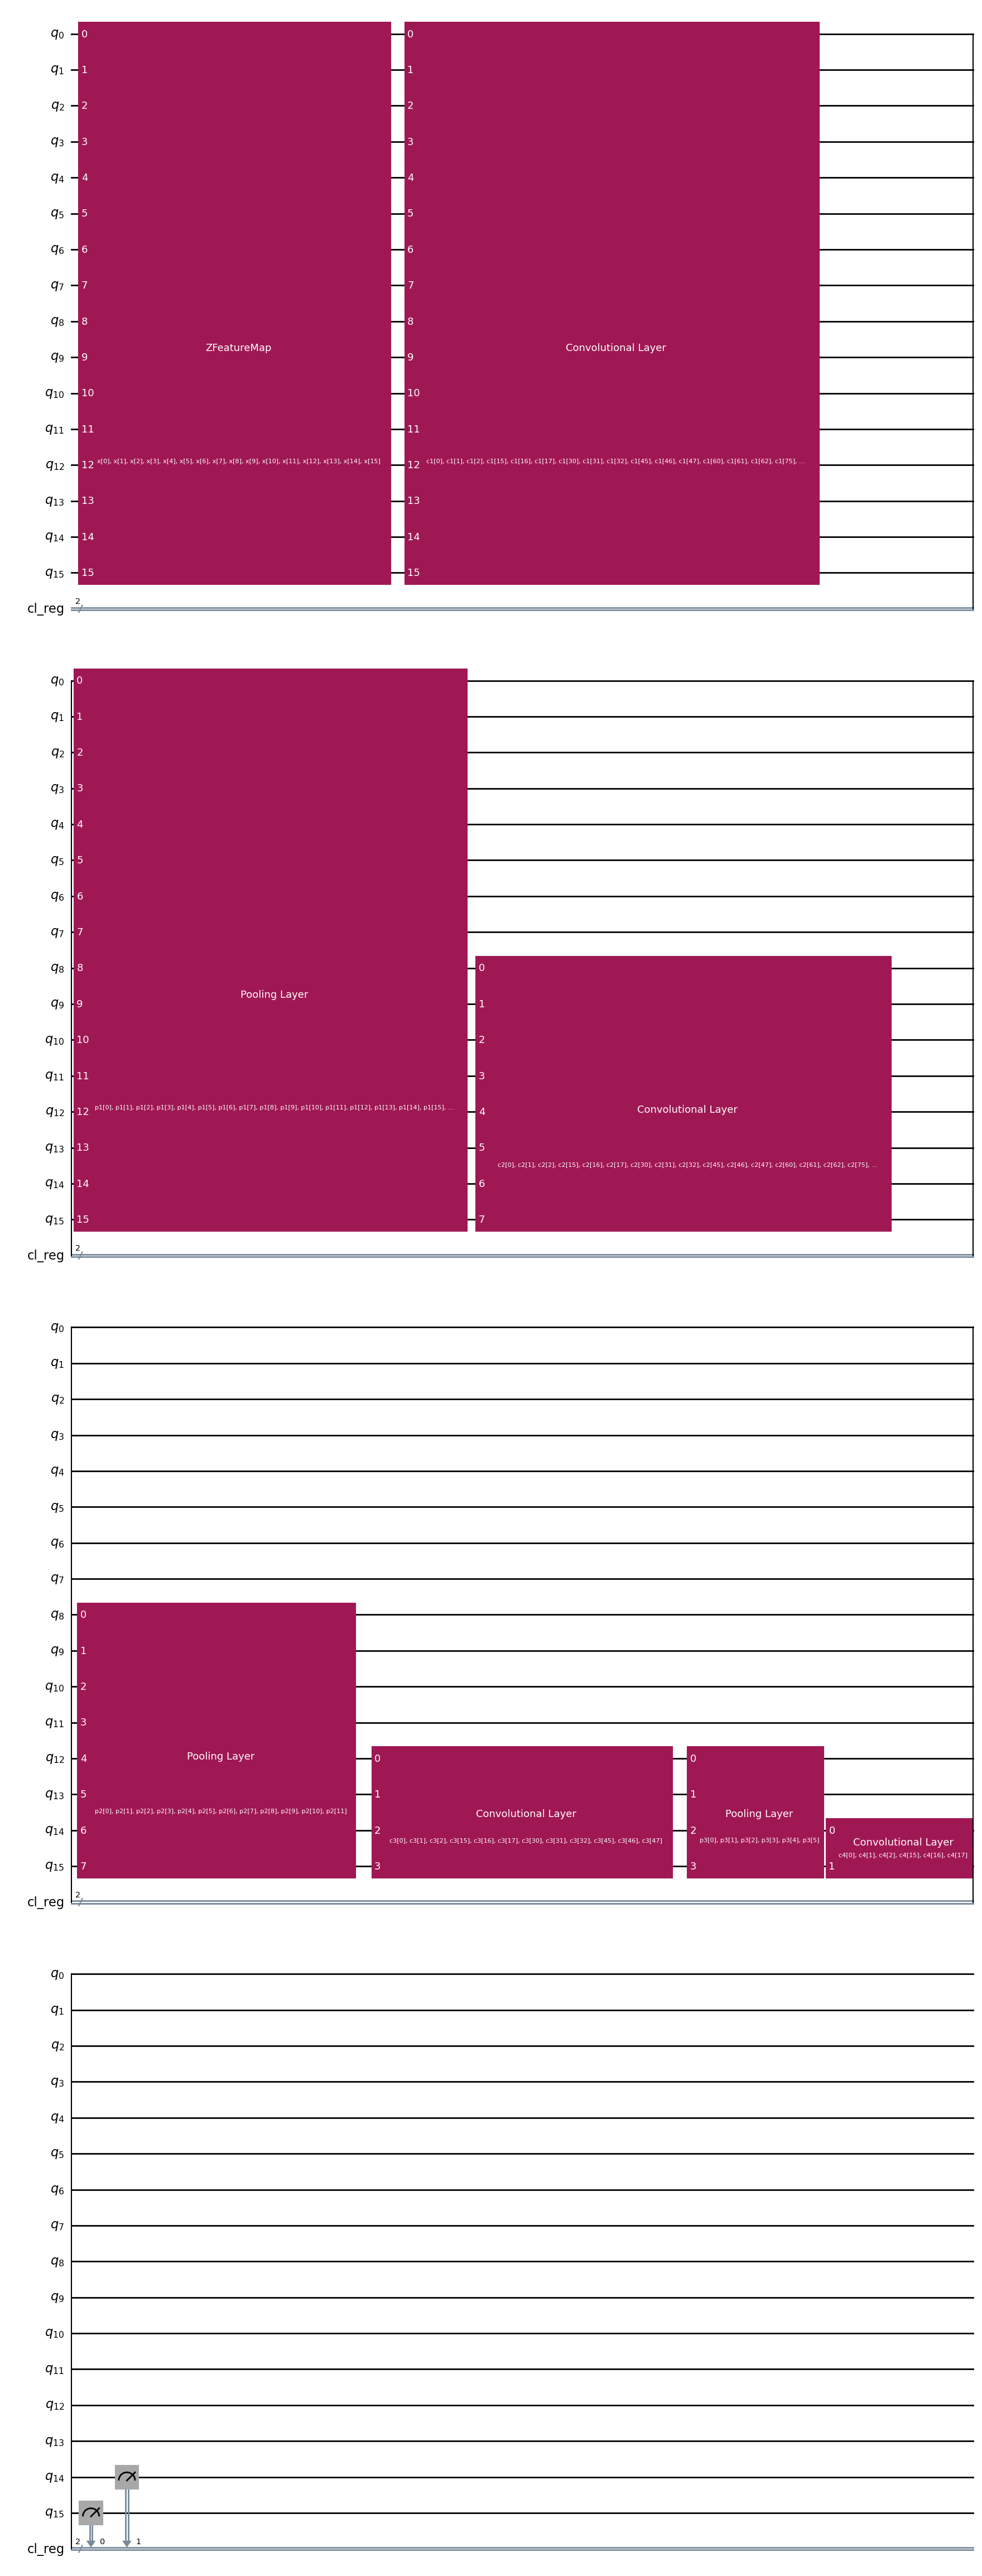

In [15]:
from qiskit import ClassicalRegister, QuantumRegister
q_reg = QuantumRegister(16, "q_reg")
cl_reg = ClassicalRegister(2, "cl_reg")
feature_map = ZFeatureMap(16)
ansatz = QuantumCircuit(q_reg, cl_reg, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# Fourth Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# Fourth Pooling Layer
# ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)
ansatz.measure(-1,0)
ansatz.measure(-2,1)

# Combining the feature map and ansatz
circuit = QNNCircuit(16)
circuit.feature_map = feature_map
circuit.ansatz = ansatz

display(circuit.draw("mpl"))

In [16]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    
  
    print("weights", weights)
    print("objective function value", objective_func_vals)
    
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)

    plt.show()

In [17]:
from qiskit_aer import AerSimulator
AerSimulator().available_devices()
AerSimulator().available_methods()

('automatic',
 'statevector',
 'density_matrix',
 'stabilizer',
 'matrix_product_state',
 'extended_stabilizer',
 'unitary',
 'superop',
 'tensor_network')

In [18]:
# backend = AerSimulator(device='GPU')


In [19]:
from qiskit_aer import AerError
from qiskit_aer.primitives import Sampler
from qiskit.compiler import transpile

# sim = AerSimulator(method='statevector')
# sim_gpu = AerSimulator(method='tensor_network', device='GPU')
# circuit = transpile(circuit, backend = sim)
sampler = Sampler()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")

classifier = SamplerQNN(
    sampler = sampler,
    circuit = circuit,
    output_shape = 2,
    interpret = lambda x: x%2,
    )

sampler_classifier = NeuralNetworkClassifier(neural_network=classifier, optimizer=COBYLA(maxiter=20), warm_start = True, callback=callback_graph)

/tmp/ipykernel_92369/298094130.py:12: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  classifier = SamplerQNN(


In [20]:
x_reshaped = []
x1_reshaped = []

for g in resized_train_images:
    x_reshaped.append(g.reshape(1,16))

for g in resized_test_images:
    x1_reshaped.append(g.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    final_x.append(entry[0])

for entry in x1_reshaped:
    final_x1.append(entry[0])

# Easier to work with names
x = final_x
y = train_labels
x1 = final_x1
y1 = test_labels

# Setting labels to 0, 1, or 2 to properly process in samplerqnn.
y_temp = []
y1_temp = []

for entry in y:
    if entry == a:
        y_temp.append(0)
    elif entry == b:
        y_temp.append(1)
    else: y_temp.append(2)
y=y_temp

for entry in y1:
    if entry == a:
        y1_temp.append(0)
    elif entry == b:
        y1_temp.append(1)
    else: y1_temp.append(2)
y1=y_temp

x = x[0:1000]
y = y[0:1000]
x1 = x1[0:1000]
y1 = y1[0:1000]

In [21]:
counta = 0
countb = 0
countc = 0
for i in range(len(y)):
    if y[i] == 0:
        counta+=1
    elif y[i] == 1:
        countb+=1
    else: countc+=1
print(counta, countb)

def balance_lists(x, y, max_count=452):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1

    return x_balanced, y_balanced

x, y = balance_lists(x, y)

counta = 0
countb = 0
countc = 0
for i in range(len(y)):
    if y[i] == 0:
        counta+=1
    elif y[i] == 1:
        countb+=1
    else: countc+=1
print(counta, countb)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

print(x)
print(y)

477 523
452 452
[[0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 [0.         0.         0.0341942  ... 0.43195325 0.         0.        ]
 ...
 [0.         0.4734389  0.20214808 ... 0.5202045  0.43572468 0.        ]
 [0.         1.0911974  0.37714198 ... 0.7135526  1.108546   0.08975979]
 [0.01684568 0.7273811  0.55842155 ... 0.897095   0.7303983  0.        ]]
[1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1
 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0
 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1
 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1
 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1
 1 1 1 0 0 1 0 

In [ ]:
def fun(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

# Calling this function
x,y = fun(x,y)


print(x)
print(y)

counta = 0
countb = 0
countc = 0
for i in range(len(y)):
    if y[i] == 0:
        counta+=1
    elif y[i] == 1:
        countb+=1
    else: countc+=1
print(counta, countb)

[[0.         0.         0.21245664 ... 0.11766829 0.37915343 0.        ]
 [0.         0.         0.         ... 0.4447761  0.11490258 0.        ]
 [0.         0.00527999 0.4430161  ... 0.52045596 0.         0.        ]
 ...
 [0.         0.21849091 0.39147332 ... 0.91519785 0.5564101  0.        ]
 [0.03796563 0.6723184  0.1536225  ... 0.47519886 0.55993015 0.        ]
 [0.         0.28511932 0.0206171  ... 0.         0.39851335 0.        ]]
[1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0
 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 0 1
 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1
 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0
 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1
 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1
 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0
 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 

weights [0.22245443 0.83516372 0.06296942 0.7267536  0.0577739  1.7628419
 0.6233952  0.04676166 0.59026209 0.54981804 0.1033859  0.15625643
 1.60186313 0.84348725 0.6112412  0.5223035  0.54968958 0.7281867
 0.03792105 0.1212368  0.65922931 0.25460714 0.50713305 0.73039522
 0.15339616 0.83439026 0.01238897 0.00271808 0.59259093 0.97590764
 0.07207693 0.21667231 0.22110244 0.81504918 0.05461491 0.32270969
 0.89430448 0.78024356 0.25754134 0.11627955 0.73460929 0.74160273
 0.31000186 0.37518427 0.40480708 0.60398113 0.64972669 0.90470871
 0.93721483 0.64814035 0.36278287 0.77850384 0.1335672  0.20380178
 0.77150076 0.01722831 0.47082058 0.2871287  0.761117   0.19756018
 0.72070066 0.12150473 0.45353381 0.53164593 0.95167472 0.76598799
 0.40164838 0.14479687 0.33419022 0.25977333 0.38795036 0.70334966
 0.70664495 0.29035534 0.74865722 0.56920465 0.24575428 0.07361086
 0.5755881  0.07439143 0.88042841 0.09236761 0.95538456 0.32751722
 0.29204464 0.09347568 0.64390019 0.03563834 0.46534646 

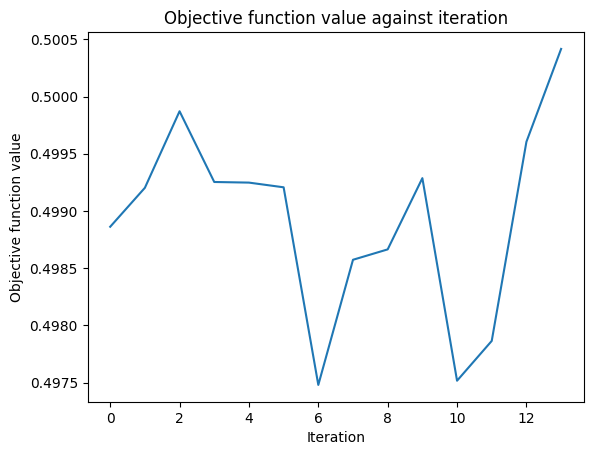

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [23]:
sampler_classifier.fit(x,y)

In [ ]:
print(f"Accuracy from the train data: {np.round(100 * sampler_classifier.score(x, y), 2)}%")

Accuracy from the train data: 74.0%


In [ ]:
y_predict = sampler_classifier.predict(x1)
print(f"Accuracy from the test data: {np.round(100 * sampler_classifier.score(x1, y1), 2)}%")

Accuracy from the test data: 51.0%


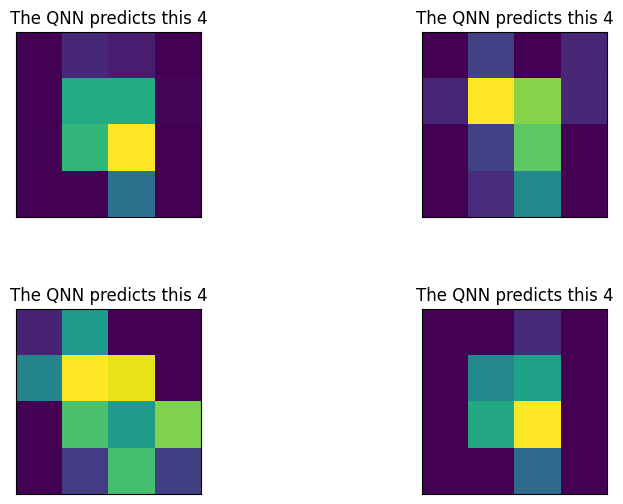

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 0:
        ax[i // 2, i % 2].set_title("The QNN predicts this is 3")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QNN predicts this 4")
    if y_predict[i] == 2:
        ax[i // 2, i % 2].set_title("The QNN predicts this 5")   
    if y_predict[i] == 3:
        ax[i // 2, i % 2].set_title("The QNN predicts this 6") 
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [ ]:
y_predict

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,

In [ ]:
y1

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,

In [ ]:
weight = sampler_classifier.weights 
weight

array([ 1.83952862,  1.52479159,  1.81320452,  0.13580988,  1.95377345,
        0.92088019,  0.76583135,  0.67035758,  2.29165361,  0.46889235,
        0.05265535,  1.9084972 ,  1.03904575,  2.29881007,  2.35671797,
        1.99659814,  2.41342362,  0.83918688,  1.84533277,  1.73054643,
        1.71904992,  1.65377031,  1.25302546,  0.08583622,  0.24934647,
        0.1853042 ,  0.90353022,  0.65402178,  0.38533666,  1.14882203,
        0.37082703,  0.56260119,  0.97954926,  1.81929931,  1.70208333,
        1.90702012,  3.01308348,  0.51553126,  1.24174614,  1.17482702,
        0.37495289,  0.65461261,  0.31993737,  1.87407861,  0.38483127,
        0.68368823,  1.63141153,  1.84466247,  1.37322843,  1.48138645,
        1.33587428,  0.23634291,  0.46240834,  0.36360372,  0.28629507,
        0.2980126 ,  1.05483677,  0.64382515,  0.13929049,  0.88097943,
        2.49563235,  0.22034071,  0.8935895 , -0.22833837, -0.24322004,
        0.02191143,  1.64293611,  0.50807441,  0.48939845, -0.14